In [1]:
%matplotlib inline
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import animation as ani
from IPython.display import HTML
import pickle
from AsymptoticRingModeSolver import Clothoid3, SystemParameters, Resonance

Lr = (2*math.pi) * (120e-6)     # Length of the resonator
omega_c = 9e10                  # Resonator/waveguide coupling parameter (2pi Hz)

# Asymptotic Mode Generation - Example

In this example file, we show how to generate the asymptotic field modes for a single straight waveguide coupled to an integrated resonator, and how to extract and display some important properties.

First, we start by loading in a previously generated binary file containing the fitting parameters for the ring and waveguide modes (See <i>modePropertyGeneration.ipynb</i> for details on the mode parameter fitting). Here, we will use a pregenerated fit over a range of TE00 and TE01 modes corresponding to wavelength between 1.45 \$ \mu m\$ to 1.65 \$ \mu m\$, bend radii from 0 \$\mu m^{-1}\$ to 0.05 \$\mu m^{-1}\$, and waveguide / resonator cross-section width from 2.1 \$ \mu m\$ to 2.9 \$ \mu m\$ (cross-section hight fixed at 0.38 \$ \mu m\$).

In [2]:
fitFile = open("sampleData/sampleFittedBinary", 'rb')
modePars_raw = pickle.load(fitFile)
fitFile.close()

Next, generate the class describing the resonator geometry. In this case, we will consider a triangular ring composed of a series of clothoid bends.

In [3]:
clothoidParDict = {
    "resonatorLength" : Lr,               # Length of the resonantor (m)
    "bendOrder" : 1.0,                    # Order of the clothoid bends
    "curveFraction" : 1.0,                # Fraction of the resonator length comprised of the clothoid bends (remaining length correspond to straight sections between the bends)
    "couplingLengthFraction" : 0.5        # Fraction of one triangle side corresponding to the coupling region with the waveguide
}
resonator = Clothoid3(clothoidParDict)

Construct the class that will house the properties of the system including modal and material properties.

In [4]:
systemParsDict = {
    "resonator" : resonator,                     # Resonator structure
    "lambda" : 1550e-9,                          # Reference system wavelength. Resonance with index n=0 corresponds to the resonance nearest this value, with n=+/-1 those directly adjacent. 
    "waveguideWidth" : 2.5,                      # Width of the waveguide / resonantor cross-section (um)
    "meshSize" : 300,                            # Number of discretized position bins along the length of the resonator structure
    "omega_c" : omega_c,                         # Waveguide/resonator coupling coefficient (TAKEN TO BE CONSTANT, WILL HAVE FREQUENCY AND MODE DEPENDENCE IN FUTURE UPDATE)
    "scatteringLoss_dB" : [0.3, 0.4],            # Phenomenological scattering loss coefficients [TE00, TE01] (dB/cm)
    "modePars_raw" : modePars_raw                # Dictionary of raw mode property fitting parameters
}
systemPars = SystemParameters(systemParsDict)

Plot some properties of the resonator system.

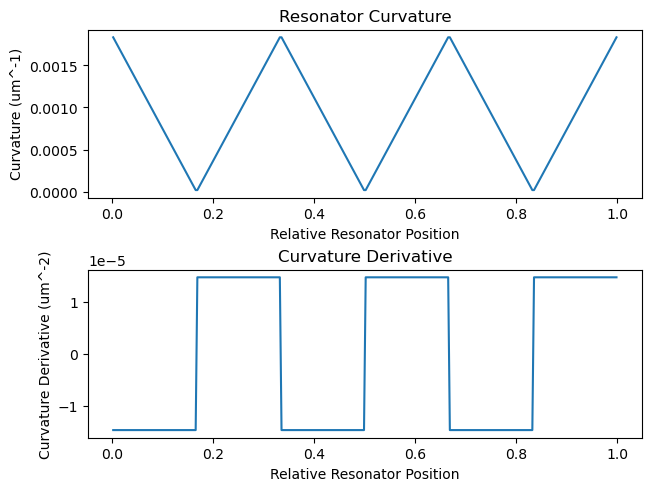

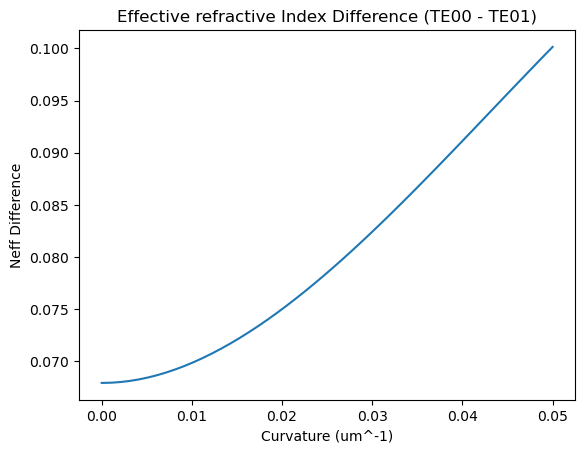

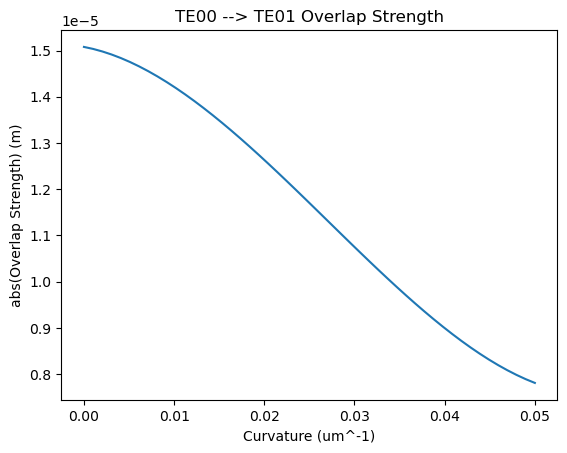

In [5]:
systemPars.PlotResonatorCurvature()
systemPars.PlotNeffDiff()
systemPars.PlotOverlapStrength()

## Single Resonance

With the system defined and intialized, we now look to generate the asymptotic field distributions for a single ring resonance. To do this, we will construct a resonance class at a fixed resonance index (Here +3 away from the system's zero index resonance), with a frequency range much smaller than the fsr of the system.

In [6]:
resonanceDict = {
    "systemPars" : systemPars,                 # System parameter class
    "Nres" : 3,                                # Resonance index (relative to the system zero index)
    "omegaRange" : 1.25e11,                    # Frequency range of the resonance (2pi Hz)
    "Nf" : 300,                                # Number of frequncy points 
    "generateSinglePassFields" : False         # Skip the generation of the resonator single pass fields (to save some time)
}
singleRes = Resonance(resonanceDict)

Generating asymptotic fields...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:05<00:00, 51.70it/s]


Now, we can plot the transmission spectra corresponding to a field input in each waveguide mode.

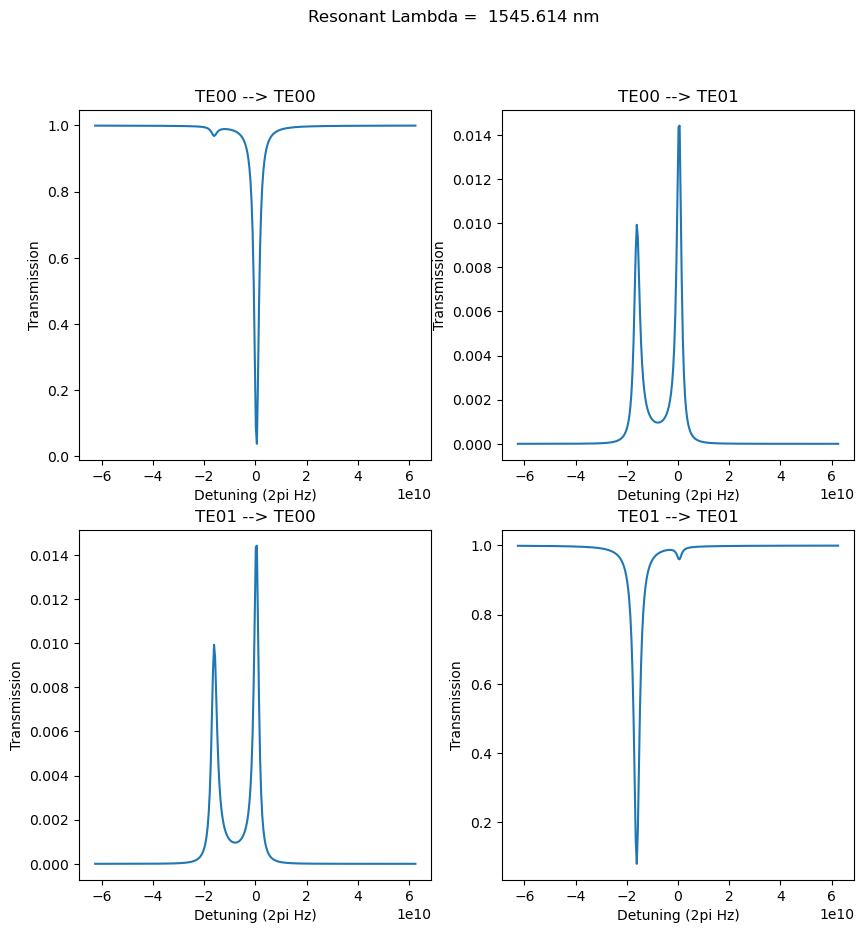

In [7]:
singleRes.PlotTransmissionSpectrum()

Note that in this particular case, the \$ n = +3 \$ mode corresponds to a nearly degenerate resonance in the TE00 and TE01 modes, leading to a resonance splitting.

We can also make an animation of the magnitude and phase of the field within the resonator as a function the resonator position, while sweeping over the frequency range. This animation is save to the provided file name, and then displayed in the cell below.

In [8]:
singleRes.RingFieldAnimation("animations/sampleFieldAnimation.mp4", interval=50)

In [9]:
%%HTML
<video width="960" height="720" controls>
  <source src="animations/sampleFieldAnimation.mp4" type="video/mp4">
</video>

## Multiple Resonances

When computing the asymptotic field distributions, it is assumed that the system parameters (effective index, group velocity, etc.) don't vary greatly within the given resonance range. In general, this is well satisfied when we are considering a range that is smaller than the frs of the system, but if one would like to visualize many system resonances this can lead to complications. As such, it is prefereable to instead create a series of partitions of the full range of interest, generate the field properties, then merge the results at the end. An example of this is shown below where we have defined 7 total partitions, each corresponding to a TE00 system resonance, and plotted them all within the same spectrum plot.

Generating asymptotic fields...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:36<00:00, 55.39it/s]


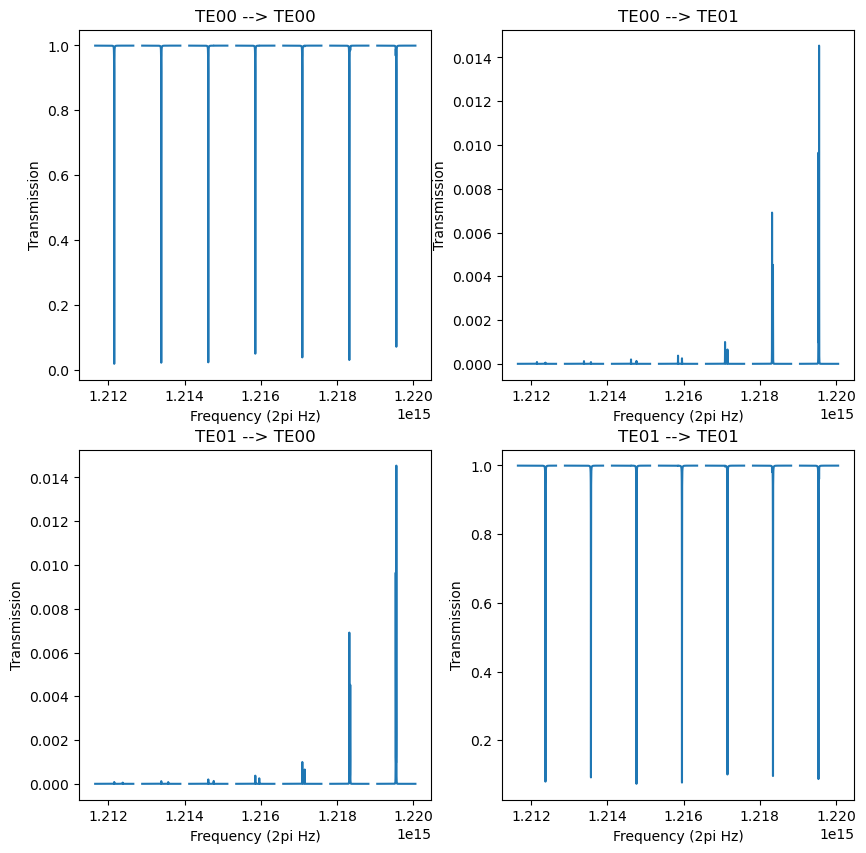

In [10]:
tempResDict = {
    "systemPars" : systemPars,                # System parameter class
    "Nres" : 0,                               # Central wavelength (m)
    "omegaRange" : 1e12,                      # Frequency range of the resonance (2pi Hz)
    "Nf" : 2000,                              # Number of frequncy points 
    "generateSinglePassFields" : False        # Skip the generation of the resonator single pass fields (to save some time)
}

resNumRange = np.arange(-3, 4)
resonances = []
for resIndex in resNumRange:
    tempResDict["Nres"] = resIndex
    resonances.append(Resonance(tempResDict))

fig, ax = plt.subplots(2,2)
fig.set_size_inches(10, 10)

for modeIndex1 in range(2):
    for modeIndex2 in range(2):
        ax[modeIndex1, modeIndex2].set_title(f"TE0{modeIndex1} --> TE0{modeIndex2}")
        ax[modeIndex1, modeIndex2].set_xlabel("Frequency (2pi Hz)")
        ax[modeIndex1, modeIndex2].set_ylabel("Transmission")
        
        for res in resonances:
            ax[modeIndex1, modeIndex2].plot(res.omega_vec , res.TransmissionSpectrum(modeIndex1, modeIndex2), color='tab:blue')

plt.show()